# Evaluation pipeline

## 0 Imports and Constants

In [1]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.insert(0, parent_dir)

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import seaborn as sns
from copy import deepcopy as dc

from utilities import split_data_into_sequences, load_sequential_time_series, reconstruct_sequential_data, Scaler, extract_features_and_targets_reg, get_discriminative_test_performance
from data_evaluation.visual.visual_evaluation import visual_evaluation
from predictive_evaluation import predictive_evaluation

In [3]:
DATA_FOLDER = Path("../../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic" / "usable" / "1y"

## 1 Load and Visualize Data

### Ways of loading data
- Laden der Originaldaten: als pd dataframe 
- Laden der synthetischen, sequentiellen Daten: als np array (GAN, (V)AE)
- Laden der synthetischen, sequentiellen Daten: als pd dataframe (brownian, algorithmit)

In [4]:
# possible types: 'timegan_lstm', 'timegan_gru', 'jitter', 'timewarp', 'autoencoder', 'vae'
syn_data_type = 'autoencoder'

In [5]:
# Load real time series
data_train_real_df = pd.read_csv(REAL_DATA_FOLDER/'mitv_prep_1y.csv')
data_train_real_numpy = dc(data_train_real_df).to_numpy()

data_test_real_df = pd.read_csv(REAL_DATA_FOLDER/'mitv_prep_3mo.csv')
data_test_real_numpy = dc(data_test_real_df).to_numpy()

if syn_data_type == 'timegan_lstm':
    # load sequential data (which should already be scaled)
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_5_lstm_unscaled.csv', shape=(28499, 12, 5))

elif syn_data_type == 'timegan_gru':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_5_gru_unscaled.csv', shape=(28499, 12, 5))

elif syn_data_type == 'autoencoder':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'8726_12_5_lstm_autoencoder.csv', shape=(8726, 12, 5))

elif syn_data_type == 'vae':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28511_12_5_lstm_vae_unscaled.csv', shape=(28511, 12, 5))

elif syn_data_type == 'jitter':
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'jittered_01.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

elif syn_data_type == 'timewarp':
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'time_warped.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

# Loot at real and syn data
df = pd.DataFrame(data_syn_numpy.reshape(-1, data_syn_numpy.shape[-1]), columns=data_train_real_df.columns)

print('\n\n syn data:\n')
print(df.describe())

print('\n\nreal train data:\n')
print(data_train_real_df.describe())

print('\n\nreal test data:\n')
print(data_test_real_df.describe())



 syn data:

       traffic_volume           temp   rain_1h       snow_1h     clouds_all
count   104712.000000  104712.000000  104712.0  1.047120e+05  104712.000000
mean      3196.964351     279.349870       0.0  1.266347e-09      40.697540
std       1877.608938      14.884194       0.0  4.027184e-07      39.007478
min          0.000000     247.150009       0.0  0.000000e+00       0.000000
25%       1297.783539     271.447609       0.0  0.000000e+00       0.000000
50%       3544.542114     281.756729       0.0  0.000000e+00      31.727083
75%       4784.060547     291.352676       0.0  0.000000e+00      86.484615
max       7716.058105     307.195068       0.0  1.302962e-04     110.427353


real train data:

       traffic_volume         temp      rain_1h      snow_1h   clouds_all
count     8759.000000  8759.000000  8759.000000  8759.000000  8759.000000
mean      3244.668912   282.208136     0.086792     0.000233    44.397306
std       1946.247953    12.114907     0.901360     0.006145

## 2 Predictive Evaluation

### Set Hyperparameters and Features

In [6]:
hyperparameters = {
    "seq_len": 12,
    "lr": 0.0001,
    "batch_size": 32,
    "hidden_size": 12,
    "num_layers": 1,
    "bidirectional": True,
    "num_evaluation_runs": 10,
    "num_epochs": 500,
    "device": 'cuda' if torch.cuda.is_available() else 'cpu'
}

In [7]:
# evaluate predictive performance
predictive_results = predictive_evaluation(
    data_train_real=data_train_real_numpy, 
    data_test_real=data_test_real_numpy,
    data_syn=data_syn_numpy, 
    hyperparameters=hyperparameters, 
    include_baseline=True, 
    verbose=True)

# save results
bidirectionality = "bi" if hyperparameters["bidirectional"] else 'no_bi'
predictive_results.to_csv(DATA_FOLDER / f"results_{syn_data_type}_{hyperparameters['num_epochs']}_{hyperparameters['num_evaluation_runs']}_{bidirectionality}.csv", index=False)

# split in mse and mae results
mse_results = predictive_results.loc[predictive_results['Metric'] == 'MSE']
mae_results = predictive_results.loc[predictive_results['Metric'] == 'MAE']

HYPERPARAMETERS:
seq_len :  12
lr :  0.0001
batch_size :  32
hidden_size :  12
num_layers :  1
bidirectional :  True
num_evaluation_runs :  10
num_epochs :  500
device :  cpu
Synthetic Data is sequential: True
Shape of the data after splitting into sequences: (8748, 12, 5)
Shape of the data after splitting into sequences: (1057, 12, 5)
Shape of the data after splitting into sequences: (1056, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 0.22210548995878465 // Train Acc: 0.011405109489051095
Val Loss: 0.1790074733657735 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.034015577905097585 // Train Acc: 0.011405109489051095
Val Loss: 0.0348062379669179 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.014117488672831061 // Train Acc: 0.011405109489051095
Val Loss: 0.015417480943998432 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.011157282343028915 // Train Acc: 0.011405109489051095
Val Loss: 0.012148211258189642 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009685477176868105 // Train Acc: 0.011405109489051095
Val Loss: 0.010396832001039429 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008719537041343775 // Train Acc: 0.011405109489051095
Val Loss: 0.00921684383715996 // Val Acc: 0.0
**

c:\Users\fanny\Documents\ArnesShit\time_series_data_augmentation\data_evaluation\predictive\predictive_evaluation.py:277: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{'Model': evaluation_method, 'Metric': 'MAE', 'Error': mae}])], ignore_index=True)
 10%|█         | 1/10 [01:06<09:54, 66.08s/it]

INFO: Validation loss did not improve in epoch 156
Early stopping after 156 epochs
Epoch: 1
Train Loss: 0.160780620400923 // Train Acc: 0.011405109489051095
Val Loss: 0.10367059085846823 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.02480298150534721 // Train Acc: 0.011405109489051095
Val Loss: 0.02697919076308608 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.012489895287044618 // Train Acc: 0.011405109489051095
Val Loss: 0.013580722046112093 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.010546062049884213 // Train Acc: 0.011405109489051095
Val Loss: 0.011257396100143738 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.00906693335388019 // Train Acc: 0.011405109489051095
Val Loss: 0.009747682474827504 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008232508380693403 //

 20%|██        | 2/10 [04:32<19:49, 148.63s/it]

Epoch: 1
Train Loss: 0.16187112863060005 // Train Acc: 0.011405109489051095
Val Loss: 0.1243111441624077 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.0202860610481406 // Train Acc: 0.011405109489051095
Val Loss: 0.023113673203624785 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.012585175634926036 // Train Acc: 0.011405109489051095
Val Loss: 0.014175390944514862 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.00960677035002507 // Train Acc: 0.011405109489051095
Val Loss: 0.01076837396591573 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.008389263383255605 // Train Acc: 0.011405109489051095
Val Loss: 0.009222359239014195 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007343720432488167 // Train Acc: 0.011405109489051095
Val Loss: 0.007882400662364328 // Val Acc: 0.0
***

 30%|███       | 3/10 [07:57<20:21, 174.53s/it]

Epoch: 1
Train Loss: 0.22886953982150685 // Train Acc: 0.011405109489051095
Val Loss: 0.17974434130797712 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.022791502271595335 // Train Acc: 0.011405109489051095
Val Loss: 0.024727845126215148 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.011040898988679404 // Train Acc: 0.011405109489051095
Val Loss: 0.012487099242314477 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.008364362908564644 // Train Acc: 0.011405109489051095
Val Loss: 0.009430998111116317 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.006930770855957819 // Train Acc: 0.011405109489051095
Val Loss: 0.007959624177173656 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.006359612670332792 // Train Acc: 0.011405109489051095
Val Loss: 0.007219152607242851 // Val Acc: 0.

 40%|████      | 4/10 [08:55<12:49, 128.23s/it]

INFO: Validation loss did not improve in epoch 139
Early stopping after 139 epochs
Epoch: 1
Train Loss: 0.10500474046426315 // Train Acc: 0.011405109489051095
Val Loss: 0.0921382558915545 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.020692232336821784 // Train Acc: 0.011405109489051095
Val Loss: 0.023085927029195076 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.011267573623680067 // Train Acc: 0.011405109489051095
Val Loss: 0.012599214363624068 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.009450400125381475 // Train Acc: 0.011405109489051095
Val Loss: 0.01016018950544736 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.008463698929604007 // Train Acc: 0.011405109489051095
Val Loss: 0.008864300246761344 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007977629105057431

 50%|█████     | 5/10 [10:04<08:54, 106.91s/it]

INFO: Validation loss did not improve in epoch 167
Early stopping after 167 epochs
Epoch: 1
Train Loss: 0.14785252414970068 // Train Acc: 0.011405109489051095
Val Loss: 0.10867415127508781 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.024278532812222295 // Train Acc: 0.011405109489051095
Val Loss: 0.02677100551698138 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.012320382784402855 // Train Acc: 0.011405109489051095
Val Loss: 0.013575275942190167 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.010267976039245615 // Train Acc: 0.011405109489051095
Val Loss: 0.011195445063469164 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.008748925791715143 // Train Acc: 0.011405109489051095
Val Loss: 0.009586442446829203 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.00826023834146538

 60%|██████    | 6/10 [11:02<06:00, 90.25s/it] 

INFO: Validation loss did not improve in epoch 140
Early stopping after 140 epochs
Epoch: 1
Train Loss: 0.402111201621864 // Train Acc: 0.02281021897810219
Val Loss: 0.2777495950131732 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.034108392642742964 // Train Acc: 0.011405109489051095
Val Loss: 0.038929433534469676 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.013723369303710051 // Train Acc: 0.011405109489051095
Val Loss: 0.015274199095609434 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.010342441955972191 // Train Acc: 0.011405109489051095
Val Loss: 0.011324266314177829 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.008453163416481774 // Train Acc: 0.011405109489051095
Val Loss: 0.009137410735574496 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0073733065548407285 

 70%|███████   | 7/10 [14:29<06:25, 128.49s/it]

Epoch: 1
Train Loss: 0.2870382928819715 // Train Acc: 0.0
Val Loss: 0.20197592716773644 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.03546545294922416 // Train Acc: 0.011405109489051095
Val Loss: 0.03904545471510466 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.015252231016506978 // Train Acc: 0.011405109489051095
Val Loss: 0.01682694207685178 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.011280930550288015 // Train Acc: 0.011405109489051095
Val Loss: 0.01212804315967814 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009361704691214636 // Train Acc: 0.011405109489051095
Val Loss: 0.009623033453381676 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008374145157409179 // Train Acc: 0.011405109489051095
Val Loss: 0.008473469026605873 // Val Acc: 0.0
********************

 80%|████████  | 8/10 [17:53<05:05, 152.67s/it]

Epoch: 1
Train Loss: 0.19753476507268355 // Train Acc: 0.011405109489051095
Val Loss: 0.15085787146295737 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.02987731278391324 // Train Acc: 0.011405109489051095
Val Loss: 0.03226102086003212 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.012906493129205285 // Train Acc: 0.011405109489051095
Val Loss: 0.014458552804118133 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.010817387969365657 // Train Acc: 0.011405109489051095
Val Loss: 0.01193694130736677 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009741514870203543 // Train Acc: 0.011405109489051095
Val Loss: 0.010519461651497027 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008946076857204801 // Train Acc: 0.011405109489051095
Val Loss: 0.009481617300908136 // Val Acc: 0.0
*

 90%|█████████ | 9/10 [21:18<02:48, 168.85s/it]

Epoch: 1
Train Loss: 0.15119626334983938 // Train Acc: 0.011405109489051095
Val Loss: 0.1248246837160824 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.028642419718858534 // Train Acc: 0.011405109489051095
Val Loss: 0.030800637159058276 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.012938806682614351 // Train Acc: 0.011405109489051095
Val Loss: 0.014368503683191888 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.00950837907309977 // Train Acc: 0.011405109489051095
Val Loss: 0.010676753416191787 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.00834480587632674 // Train Acc: 0.011405109489051095
Val Loss: 0.009454017354394583 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007211602977426029 // Train Acc: 0.011405109489051095
Val Loss: 0.008609131386037916 // Val Acc: 0.0
*

100%|██████████| 10/10 [24:43<00:00, 148.34s/it]


Shape of the data after splitting into sequences: (6996, 12, 5)
Shape of the data after splitting into sequences: (1741, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 0.18400539021479756 // Train Acc: 0.014269406392694063
Val Loss: 0.11322531474923546 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.028744381388913005 // Train Acc: 0.014269406392694063
Val Loss: 0.02452534359287132 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.014244632024135118 // Train Acc: 0.014269406392694063
Val Loss: 0.012249933191659776 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.011330542563924302 // Train Acc: 0.014269406392694063
Val Loss: 0.009245870292017405 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009833029948162196 // Train Acc: 0.014269406392694063
Val Loss: 0.008016934207725254 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008901164433217212 // Train Acc: 0.014269406392694063
Val Loss: 0.0073631739540194925 // Val Acc: 0.

 10%|█         | 1/10 [02:48<25:20, 168.91s/it]

Epoch: 1
Train Loss: 0.46435427618081165 // Train Acc: 0.028538812785388126
Val Loss: 0.3194805631583387 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.035419166500607856 // Train Acc: 0.014269406392694063
Val Loss: 0.02968446785076098 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.01498730512352907 // Train Acc: 0.014269406392694063
Val Loss: 0.012420032528991048 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.011012147651713121 // Train Acc: 0.014269406392694063
Val Loss: 0.008984813411635432 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.00902037007508791 // Train Acc: 0.014269406392694063
Val Loss: 0.0073046235494654286 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008188979710839246 // Train Acc: 0.014269406392694063
Val Loss: 0.006503539363091642 // Val Acc: 0.0
*

 20%|██        | 2/10 [05:38<22:32, 169.10s/it]

Epoch: 1
Train Loss: 0.2926192426858427 // Train Acc: 0.028538812785388126
Val Loss: 0.1945219493725083 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.028522935844787725 // Train Acc: 0.014269406392694063
Val Loss: 0.02447462732141668 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.014254023827034045 // Train Acc: 0.014269406392694063
Val Loss: 0.012053683527152647 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.010782321078328577 // Train Acc: 0.014269406392694063
Val Loss: 0.009164112344892188 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009160915751129253 // Train Acc: 0.014269406392694063
Val Loss: 0.007743249787017703 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008135791619725049 // Train Acc: 0.014269406392694063
Val Loss: 0.006843358346007087 // Val Acc: 0.0
*

 30%|███       | 3/10 [08:27<19:43, 169.01s/it]

Epoch: 1
Train Loss: 0.23675295868335658 // Train Acc: 0.014269406392694063
Val Loss: 0.14281660955060613 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.03522171839629406 // Train Acc: 0.014269406392694063
Val Loss: 0.029989977401088583 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.016213022596649314 // Train Acc: 0.014269406392694063
Val Loss: 0.014371064356104895 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.012216730176186248 // Train Acc: 0.014269406392694063
Val Loss: 0.01039585719223727 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009838786886762572 // Train Acc: 0.014269406392694063
Val Loss: 0.008394414402375167 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007976243612101327 // Train Acc: 0.014269406392694063
Val Loss: 0.006981064324182543 // Val Acc: 0.0


 40%|████      | 4/10 [11:15<16:53, 168.86s/it]

Epoch: 1
Train Loss: 0.22884174253468373 // Train Acc: 0.014269406392694063
Val Loss: 0.13745062158189036 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.03757984493965428 // Train Acc: 0.014269406392694063
Val Loss: 0.03231658954173326 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.015475821974751067 // Train Acc: 0.014269406392694063
Val Loss: 0.013683828787708824 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.012126137730537926 // Train Acc: 0.014269406392694063
Val Loss: 0.01000988651490347 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.01028143997106395 // Train Acc: 0.014269406392694063
Val Loss: 0.008388530573045666 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.00928540398275318 // Train Acc: 0.014269406392694063
Val Loss: 0.007622994893145832 // Val Acc: 0.0
***

 50%|█████     | 5/10 [14:04<14:04, 168.87s/it]

Epoch: 1
Train Loss: 0.19657927031998765 // Train Acc: 0.014269406392694063
Val Loss: 0.11499797466465018 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.03364280202600373 // Train Acc: 0.014269406392694063
Val Loss: 0.02932199869643558 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.016205470024535783 // Train Acc: 0.014269406392694063
Val Loss: 0.014632169936190952 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.012264260402923135 // Train Acc: 0.014269406392694063
Val Loss: 0.010337928420102055 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.010244880454215012 // Train Acc: 0.014269406392694063
Val Loss: 0.008455888084559278 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008950575220836624 // Train Acc: 0.014269406392694063
Val Loss: 0.007321376256136732 // Val Acc: 0.0


 60%|██████    | 6/10 [15:46<09:44, 146.00s/it]

INFO: Validation loss did not improve in epoch 300
Early stopping after 300 epochs
Epoch: 1
Train Loss: 0.208334372927473 // Train Acc: 0.014269406392694063
Val Loss: 0.13295403036542913 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.041758046983039546 // Train Acc: 0.014269406392694063
Val Loss: 0.03594226610254158 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.015977838100040477 // Train Acc: 0.014269406392694063
Val Loss: 0.01337253366258334 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.011363590959051293 // Train Acc: 0.014269406392694063
Val Loss: 0.00937700823626735 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.00916606179740467 // Train Acc: 0.014269406392694063
Val Loss: 0.007583963350308212 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008081531718524267 // 

 70%|███████   | 7/10 [18:35<07:40, 153.47s/it]

Epoch: 1
Train Loss: 0.424161145506112 // Train Acc: 0.028538812785388126
Val Loss: 0.30449343459172684 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.03663805828825252 // Train Acc: 0.014269406392694063
Val Loss: 0.031805709512396294 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.014529223286984786 // Train Acc: 0.014269406392694063
Val Loss: 0.01178774856538935 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.011104886664064883 // Train Acc: 0.014269406392694063
Val Loss: 0.009024386027489196 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009346150409336708 // Train Acc: 0.014269406392694063
Val Loss: 0.007628068560734391 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.00862381793824386 // Train Acc: 0.014269406392694063
Val Loss: 0.006930665438994765 // Val Acc: 0.0
***

 80%|████████  | 8/10 [21:24<05:16, 158.46s/it]

Epoch: 1
Train Loss: 0.1698846858522119 // Train Acc: 0.014269406392694063
Val Loss: 0.11446016996421597 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.03722438081401532 // Train Acc: 0.014269406392694063
Val Loss: 0.03208153627135537 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.014928363349190892 // Train Acc: 0.014269406392694063
Val Loss: 0.0139654476957565 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.011940088516449955 // Train Acc: 0.014269406392694063
Val Loss: 0.010514959316192703 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.010547505549450732 // Train Acc: 0.014269406392694063
Val Loss: 0.009284670735624704 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.009463236410995801 // Train Acc: 0.014269406392694063
Val Loss: 0.008362165868112987 // Val Acc: 0.0
***

 90%|█████████ | 9/10 [23:21<02:25, 145.65s/it]

INFO: Validation loss did not improve in epoch 347
Early stopping after 347 epochs
Epoch: 1
Train Loss: 0.36188310258022455 // Train Acc: 0.028538812785388126
Val Loss: 0.25098984851078554 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.03316138341988875 // Train Acc: 0.014269406392694063
Val Loss: 0.028222278302366084 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.014349981874533712 // Train Acc: 0.014269406392694063
Val Loss: 0.011951019301671873 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.011532040256539096 // Train Acc: 0.014269406392694063
Val Loss: 0.009482452201403 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.00949172309565796 // Train Acc: 0.014269406392694063
Val Loss: 0.007804614453661171 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008622521730182377 //

100%|██████████| 10/10 [26:10<00:00, 157.05s/it]


Shape of the data after splitting into sequences: (8748, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 0.26621266648377456 // Train Acc: 0.0
Val Loss: 0.1772501060908491 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.030165125864672744 // Train Acc: 0.0
Val Loss: 0.02714417651295662 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.009853936598389559 // Train Acc: 0.0
Val Loss: 0.00829773748039522 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.006461702762958359 // Train Acc: 0.0
Val Loss: 0.005261326251043515 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.004672202924064458 // Train Acc: 0.0
Val Loss: 0.0038416347318244253 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0030304439144993637 // Train Acc: 0.0
Val Loss: 0.00266238122924485 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.0016280991289994284 // Trai

 10%|█         | 1/10 [02:48<25:12, 168.09s/it]

Epoch: 1
Train Loss: 0.1279630790906852 // Train Acc: 0.0
Val Loss: 0.07733871066434816 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.044944368889682916 // Train Acc: 0.0
Val Loss: 0.03982118446041237 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.013569467003589079 // Train Acc: 0.0
Val Loss: 0.011307127981192686 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.007597177797613759 // Train Acc: 0.0
Val Loss: 0.005960591363889927 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.005044946049129565 // Train Acc: 0.0
Val Loss: 0.0038932734983973204 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0031631011093252222 // Train Acc: 0.0
Val Loss: 0.0025335252041589805 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.00188175703553838 // Tra

 20%|██        | 2/10 [05:34<22:18, 167.33s/it]

Epoch: 1
Train Loss: 0.07458380750299656 // Train Acc: 0.0
Val Loss: 0.05305663181299513 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.014130067770246025 // Train Acc: 0.0
Val Loss: 0.011394837371666322 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.0072885816757350345 // Train Acc: 0.0
Val Loss: 0.00572245663497597 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.005204701718298046 // Train Acc: 0.0
Val Loss: 0.004156607719646259 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.00410839502625784 // Train Acc: 0.0
Val Loss: 0.0032964870857540517 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0030888285656400093 // Train Acc: 0.0
Val Loss: 0.002519500513815067 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.0020282868766087663 // T

 30%|███       | 3/10 [08:22<19:31, 167.30s/it]

Epoch: 1
Train Loss: 0.15789164493039046 // Train Acc: 0.0
Val Loss: 0.10773552889851007 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.027620522475473957 // Train Acc: 0.0
Val Loss: 0.023041584884578532 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.008478300964361966 // Train Acc: 0.0
Val Loss: 0.0064589079998602925 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.005249837637755629 // Train Acc: 0.0
Val Loss: 0.004125881700945849 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.003873630474666006 // Train Acc: 0.0
Val Loss: 0.0031619484451684086 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0029101947165141094 // Train Acc: 0.0
Val Loss: 0.002425147355957465 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.0023048338767345227 //

 40%|████      | 4/10 [11:09<16:43, 167.19s/it]

Epoch: 1
Train Loss: 0.2583575837280108 // Train Acc: 0.0
Val Loss: 0.15367069562727756 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.02802023785954265 // Train Acc: 0.0
Val Loss: 0.024327773397619074 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.009310032153336254 // Train Acc: 0.0
Val Loss: 0.007256092998961156 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.006592986297785181 // Train Acc: 0.0
Val Loss: 0.005116208198226311 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.0049769769350415495 // Train Acc: 0.0
Val Loss: 0.0039716073100201105 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0036666638647912062 // Train Acc: 0.0
Val Loss: 0.003143920412879776 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.0025762277535698696 // T

 50%|█████     | 5/10 [13:56<13:55, 167.16s/it]

Epoch: 1
Train Loss: 0.15722697556495122 // Train Acc: 0.0
Val Loss: 0.09980421763929453 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.028797634756064987 // Train Acc: 0.0
Val Loss: 0.02483731782571836 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.008066986447208685 // Train Acc: 0.0
Val Loss: 0.006284761272201484 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.0047811768993152705 // Train Acc: 0.0
Val Loss: 0.003894601487131281 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.0032797458182412228 // Train Acc: 0.0
Val Loss: 0.002821328735444695 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0023939400896978605 // Train Acc: 0.0
Val Loss: 0.0020639612201855265 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.0017407591995298353 //

 60%|██████    | 6/10 [16:43<11:08, 167.09s/it]

Epoch: 1
Train Loss: 0.08241737665412906 // Train Acc: 0.0
Val Loss: 0.058827621388164435 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.01934713514555739 // Train Acc: 0.0
Val Loss: 0.015595147089863365 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.008677247868633943 // Train Acc: 0.0
Val Loss: 0.006853595062751662 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.005885763196955057 // Train Acc: 0.0
Val Loss: 0.004630199890710752 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.004597808408219214 // Train Acc: 0.0
Val Loss: 0.0037645986208438196 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0036819486636413285 // Train Acc: 0.0
Val Loss: 0.0031119803665205837 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.002894674836855688 // 

 70%|███████   | 7/10 [19:30<08:21, 167.11s/it]

Epoch: 1
Train Loss: 0.12731282830612572 // Train Acc: 0.0
Val Loss: 0.08710693940520287 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.02060175855052934 // Train Acc: 0.0
Val Loss: 0.01619297316805883 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.008637057686411695 // Train Acc: 0.0
Val Loss: 0.0069250598063015124 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.00562113725641938 // Train Acc: 0.0
Val Loss: 0.004422271137379787 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.004423475774859831 // Train Acc: 0.0
Val Loss: 0.003457836563360285 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0036628552928851857 // Train Acc: 0.0
Val Loss: 0.0029045424519360745 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.002868208066734685 // Tra

 80%|████████  | 8/10 [22:17<05:34, 167.19s/it]

Epoch: 1
Train Loss: 0.3290827472324241 // Train Acc: 0.0
Val Loss: 0.234293278103525 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.02674810598353477 // Train Acc: 0.0
Val Loss: 0.023388570682568985 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.009371005199088388 // Train Acc: 0.0
Val Loss: 0.007864133924753828 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.0060338664140241844 // Train Acc: 0.0
Val Loss: 0.004866214430975643 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.004575572303521817 // Train Acc: 0.0
Val Loss: 0.003623188716698099 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0035485581029206514 // Train Acc: 0.0
Val Loss: 0.002851108081681146 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.002606090460026841 // Train

 90%|█████████ | 9/10 [25:05<02:47, 167.29s/it]

Epoch: 1
Train Loss: 0.1749766087882459 // Train Acc: 0.0
Val Loss: 0.11038127900524573 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.02751800289045866 // Train Acc: 0.0
Val Loss: 0.023841241527010094 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.008666235285908937 // Train Acc: 0.0
Val Loss: 0.006833514643155716 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.0063834436494032065 // Train Acc: 0.0
Val Loss: 0.0049382136817174875 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.004867546085999709 // Train Acc: 0.0
Val Loss: 0.0038872605782340874 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0036323455488734527 // Train Acc: 0.0
Val Loss: 0.0030952931466427715 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.002789806771798051 // 

100%|██████████| 10/10 [27:52<00:00, 167.22s/it]


Shape of the data after splitting into sequences: (8748, 12, 5)
Shape of the data after splitting into sequences: (1057, 12, 5)
Shape of the data after splitting into sequences: (1056, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 0.14975550012676628 // Train Acc: 0.0
Val Loss: 0.07418660808573752 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.009319678165267638 // Train Acc: 0.0
Val Loss: 0.011682132782880217 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.005133006875926775 // Train Acc: 0.0
Val Loss: 0.007611056522685377 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.00421502664309613 // Train Acc: 0.0
Val Loss: 0.006380569456857355 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.0038712001400867772 // Train Acc: 0.0
Val Loss: 0.006019733880427392 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.003577735450477816 // Train Acc: 0.0
Val Loss: 0.0058096172835897 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.0032913469848404146 // Trai

 10%|█         | 1/10 [06:35<59:16, 395.17s/it]

Epoch: 1
Train Loss: 0.08375596817475582 // Train Acc: 0.0
Val Loss: 0.061064453905119616 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.008387789447692699 // Train Acc: 0.0
Val Loss: 0.01104611878091579 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.005706742629810011 // Train Acc: 0.0
Val Loss: 0.008394082340494017 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.004642807388843345 // Train Acc: 0.0
Val Loss: 0.00707216581042089 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.004215186349434652 // Train Acc: 0.0
Val Loss: 0.0063807440182084545 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.003877811071344173 // Train Acc: 0.0
Val Loss: 0.005519724471549339 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.003478464140278803 // Tra

 20%|██        | 2/10 [07:55<27:59, 209.92s/it]

INFO: Validation loss did not improve in epoch 101
Early stopping after 101 epochs
Epoch: 1
Train Loss: 0.09309038365646256 // Train Acc: 0.0
Val Loss: 0.06430441897143335 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.008819708781692925 // Train Acc: 0.0
Val Loss: 0.011330292416352998 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.004998788094500052 // Train Acc: 0.0
Val Loss: 0.007259120938696843 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.0037640217274309933 // Train Acc: 0.0
Val Loss: 0.006025559618137777 // Val Acc: 0.0
**************************************************
INFO: Validation loss did not improve in epoch 41
Epoch: 41
Train Loss: 0.0034337883414632523 // Train Acc: 0.0
Val Loss: 0.005960657227072208 // Val Acc: 0.0
**************************************************
INFO: Validation loss did not improve in epoch 42
INFO: Validation loss d

 30%|███       | 3/10 [08:30<15:12, 130.30s/it]

INFO: Validation loss did not improve in epoch 45
Early stopping after 45 epochs
Epoch: 1
Train Loss: 0.10352233257076586 // Train Acc: 0.0
Val Loss: 0.06932306256802644 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.008451589265705462 // Train Acc: 0.0
Val Loss: 0.010962053660905975 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.005004079963357896 // Train Acc: 0.0
Val Loss: 0.007378769079771112 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.004316604143028595 // Train Acc: 0.0
Val Loss: 0.006640136899317012 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.0038702141013531905 // Train Acc: 0.0
Val Loss: 0.006082287838901667 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0035501503762516654 // Train Acc: 0.0
Val Loss: 0.0056718101053882175 // Val Acc: 0.0
****************

 40%|████      | 4/10 [09:39<10:36, 106.06s/it]

INFO: Validation loss did not improve in epoch 87
Early stopping after 87 epochs
Epoch: 1
Train Loss: 0.11127483466609468 // Train Acc: 0.0
Val Loss: 0.06924112141132355 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.008635097853699465 // Train Acc: 0.0
Val Loss: 0.011324105921256192 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.0048775333677924205 // Train Acc: 0.0
Val Loss: 0.007265059386982638 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.004423429614117699 // Train Acc: 0.0
Val Loss: 0.006505433285115834 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.004042465740753512 // Train Acc: 0.0
Val Loss: 0.006096621064524002 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.00365960663281359 // Train Acc: 0.0
Val Loss: 0.005738278779009467 // Val Acc: 0.0
*******************

 50%|█████     | 5/10 [10:36<07:20, 88.13s/it] 

INFO: Validation loss did not improve in epoch 71
Early stopping after 71 epochs
Epoch: 1
Train Loss: 0.08641572474115537 // Train Acc: 0.0
Val Loss: 0.06757624562391464 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.008330214898684275 // Train Acc: 0.0
Val Loss: 0.011068000667043687 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.005836411341368238 // Train Acc: 0.0
Val Loss: 0.008352521125583308 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.004267822946875119 // Train Acc: 0.0
Val Loss: 0.006756392536986181 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.0038439769273256913 // Train Acc: 0.0
Val Loss: 0.006427687966018258 // Val Acc: 0.0
**************************************************
INFO: Validation loss did not improve in epoch 48
INFO: Validation loss did not improve in epoch 49
INFO: Validation loss did 

 60%|██████    | 6/10 [11:17<04:48, 72.19s/it]

INFO: Validation loss did not improve in epoch 52
Early stopping after 52 epochs
Epoch: 1
Train Loss: 0.09184693162698959 // Train Acc: 0.0
Val Loss: 0.06365245531367905 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.008695900146217433 // Train Acc: 0.0
Val Loss: 0.011239560293581556 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.00564669391860329 // Train Acc: 0.0
Val Loss: 0.008083940093295978 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.004670045762013183 // Train Acc: 0.0
Val Loss: 0.006771822956472854 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.004281433355077034 // Train Acc: 0.0
Val Loss: 0.006330754392205135 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.003844498796729027 // Train Acc: 0.0
Val Loss: 0.006018102730569594 // Val Acc: 0.0
********************

 70%|███████   | 7/10 [12:08<03:15, 65.22s/it]

INFO: Validation loss did not improve in epoch 64
Early stopping after 64 epochs
Epoch: 1
Train Loss: 0.09847451130292588 // Train Acc: 0.0
Val Loss: 0.05951713239226271 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.008338244862748494 // Train Acc: 0.0
Val Loss: 0.010795941285323352 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.005006912233598145 // Train Acc: 0.0
Val Loss: 0.007006158418816459 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.004242680294646062 // Train Acc: 0.0
Val Loss: 0.006454611265593592 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.0038499565124877778 // Train Acc: 0.0
Val Loss: 0.006241122527760179 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0033115616174762934 // Train Acc: 0.0
Val Loss: 0.005853098015958334 // Val Acc: 0.0
*****************

 80%|████████  | 8/10 [18:44<05:41, 170.53s/it]

Epoch: 1
Train Loss: 0.058259280810517414 // Train Acc: 0.0
Val Loss: 0.059420687420403254 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.008310544743235402 // Train Acc: 0.0
Val Loss: 0.011034261914627516 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.004525079480910817 // Train Acc: 0.0
Val Loss: 0.007129419314236764 // Val Acc: 0.0
**************************************************
INFO: Validation loss did not improve in epoch 27
INFO: Validation loss did not improve in epoch 28
INFO: Validation loss did not improve in epoch 29
INFO: Validation loss did not improve in epoch 30


 90%|█████████ | 9/10 [19:08<02:04, 124.93s/it]

INFO: Validation loss did not improve in epoch 31
Early stopping after 31 epochs
Epoch: 1
Train Loss: 0.09080404177532826 // Train Acc: 0.0
Val Loss: 0.06524478978313067 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.007273971702447212 // Train Acc: 0.0
Val Loss: 0.010155025626505342 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.004672579490388122 // Train Acc: 0.0
Val Loss: 0.007821998750681387 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.003741056709192775 // Train Acc: 0.0
Val Loss: 0.006960604004287983 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.0032314503266092157 // Train Acc: 0.0
Val Loss: 0.006359100095270311 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0030218432025596164 // Train Acc: 0.0
Val Loss: 0.00605051636504119 // Val Acc: 0.0
******************

100%|██████████| 10/10 [25:43<00:00, 154.39s/it]


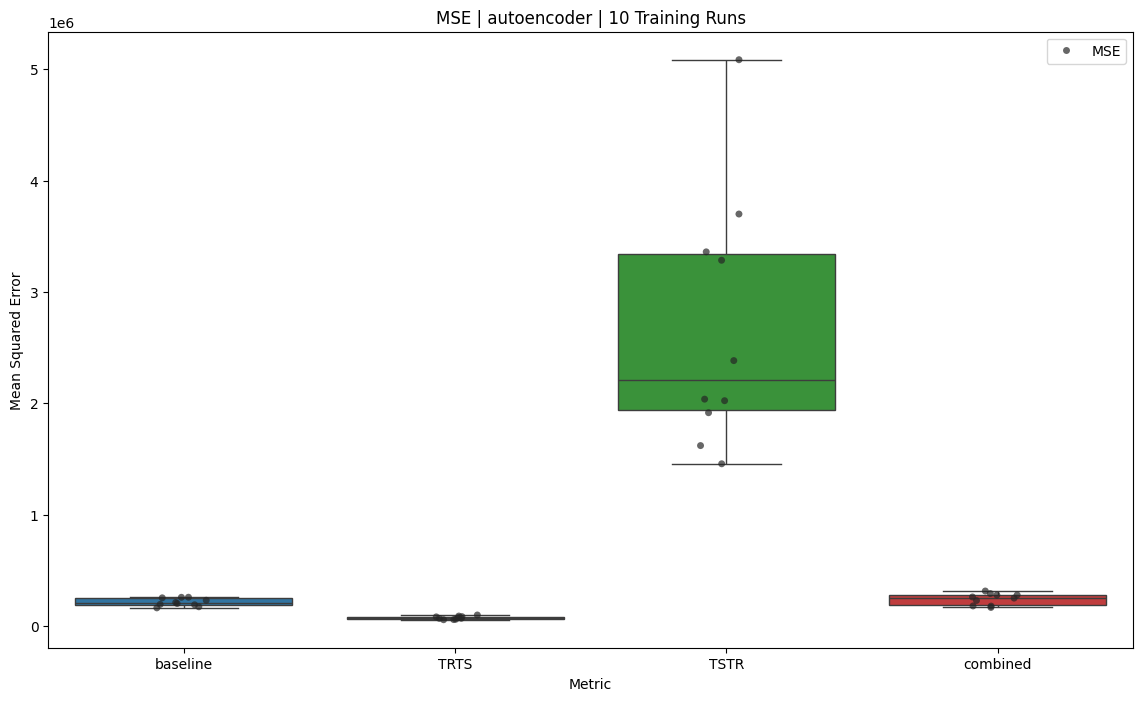

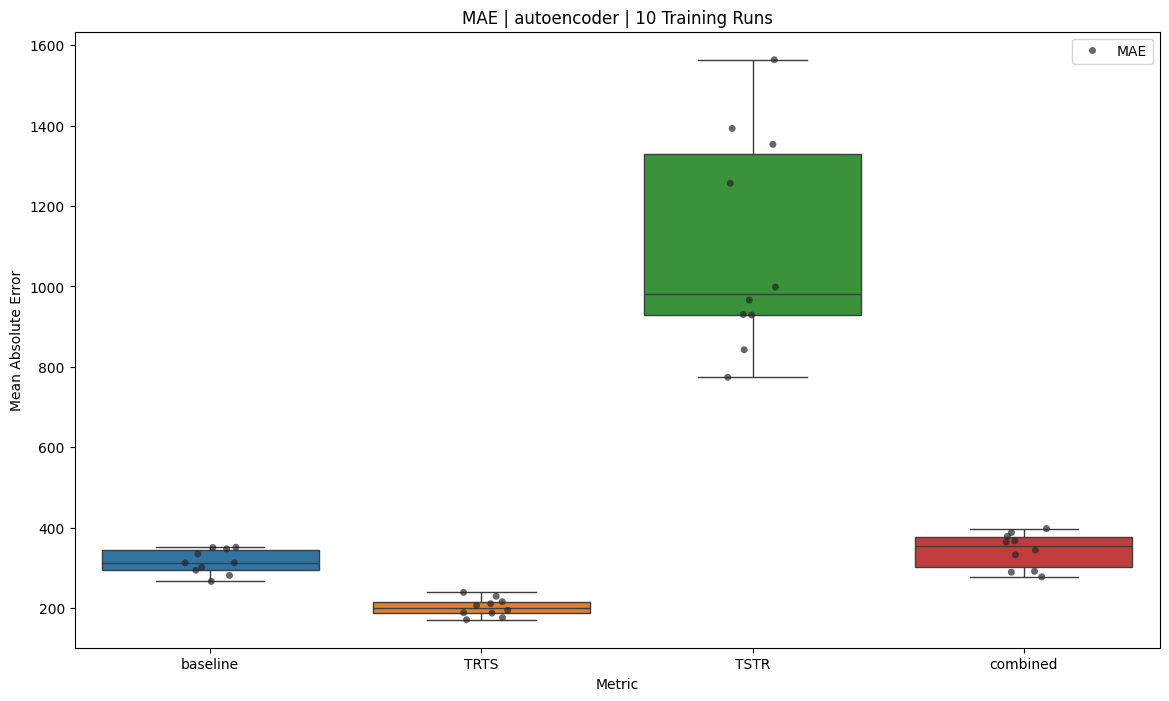

In [8]:
# plot results
plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mse_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mse_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Squared Error')
plt.xlabel('Metric')
plt.title(f'MSE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs')
plt.legend()

plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mae_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mae_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Absolute Error')
plt.xlabel('Metric')
plt.title(f'MAE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs')
plt.legend()

In [9]:
0.2*1e06

200000.0